# Example: Properties

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from tad_mctc.io import read
from tad_mctc.convert import tensor_to_numpy
from pathlib import Path
import dxtb

#### Functions

In [2]:
def fold(
    frequencies,
    intensities,
    start=800.0,
    end=4000.0,
    npts=None,
    width=4.0,
    type="Gaussian",
    normalize=True,
):
    """
    Fold frequencies and intensities within the given range
    and folding method (Gaussian/Lorentzian).
    The energy unit is cm^-1.
    normalize=True ensures the integral over the peaks to give the
    intensity.

    Taken from https://wiki.fysik.dtu.dk/ase/_modules/ase/vibrations/vibrations.html#Vibrations.fold
    """

    lctype = type.lower()
    assert lctype in ["gaussian", "lorentzian"]

    if not npts:
        npts = int((end - start) / width * 10 + 1)

    prefactor = 1
    if lctype == "lorentzian":
        intensities = intensities * width * np.pi / 2.0
        if normalize:
            prefactor = 2.0 / width / np.pi
    else:
        sigma = width / 2.0 / np.sqrt(2.0 * np.log(2.0))
        if normalize:
            prefactor = 1.0 / sigma / np.sqrt(2 * np.pi)

    # Make array with spectrum data
    spectrum = np.empty(npts)
    energies = np.linspace(start, end, npts)
    for i, energy in enumerate(energies):
        energies[i] = energy
        if lctype == "lorentzian":
            spectrum[i] = (
                intensities
                * 0.5
                * width
                / np.pi
                / ((frequencies - energy) ** 2 + 0.25 * width**2)
            ).sum()
        else:
            spectrum[i] = (
                intensities * np.exp(-((frequencies - energy) ** 2) / 2.0 / sigma**2)
            ).sum()
    return [energies, prefactor * spectrum]

#### dxtb calculation

In [3]:
device = torch.device("cpu")
dd: dxtb._types.DD = {"device": device, "dtype": torch.double}

f = Path(globals()["_dh"][0]) / "molecules" / "capsaicin.xyz"
f = Path(globals()["_dh"][0]) / "molecules" / "8-hydroxyquinoline.xyz"
f = Path(globals()["_dh"][0]) / "molecules" / "nh3-planar.xyz"
numbers, positions = read.read_from_path(f, **dd, ftype="xyz")
charge = torch.tensor(0.0, **dd)

# position gradient for intensities
pos = positions.clone()
positions.requires_grad_(True)

# dipole moment requires electric field
field_vector = torch.tensor([0.0, 0.0, 0.0], **dd, requires_grad=True)
ef = dxtb.external.new_efield(field_vector)

opts = {
    "scf_mode": "full",
    "mixer": "anderson",
    "verbosity": 6,
    "f_atol": 1e-6,
    "x_atol": 1e-6,
}

calc = dxtb.Calculator(numbers, dxtb.GFN1_XTB, opts=opts, interaction=[ef], **dd)



CALCULATION

Setup Calculator


 - Interactions      ... done
 - Classicals        ... done
 - Integrals         ... done



In [4]:
print(f.name)

nh3-planar.xyz


In [5]:
if f.name == "capsaicin.xyz":
    res  = calc.raman_numerical(numbers, positions, chrg=charge)
else:
    res  = calc.raman(numbers, positions, chrg=charge)

res.use_common_units()
freqs_dxtb, ints_dxtb = res.freqs, res.ints

if f.name == "capsaicin.xyz":
    freqs_dxtb_num, ints_dxtb_num = freqs_dxtb.clone(), ints_dxtb.clone()
else:
    res_num = calc.raman_numerical(numbers, pos, chrg=charge)
    res_num.use_common_units()
    freqs_dxtb_num, ints_dxtb_num = res_num.freqs, res_num.ints

freqs_dxtb, ints_dxtb = tensor_to_numpy(freqs_dxtb), tensor_to_numpy(ints_dxtb)
freqs_dxtb_num, ints_dxtb_num = tensor_to_numpy(freqs_dxtb_num), tensor_to_numpy(ints_dxtb_num)


Raman Spectrum
--------------
Singlepoint 
 - Classicals        ... done
 - Overlap           ... done
 - Core Hamiltonian  ... done
 - Dipole            ... done
 - Interaction Cache ... done

Starting SCF Iterations...

iter  Energy                   Delta E         Delta Pnorm     Delta q        
-----------------------------------------------------------------------------
  1   -4.90109299419220E+00    9.802186E+00    3.030600E+00    1.258874E+00
  2   -4.90117086194658E+00    7.786775E-05    1.742991E-03    1.604724E-03
  3   -4.90124645008638E+00    7.558814E-05    1.717353E-03    1.580897E-03
  4   -4.90131982575430E+00    7.337567E-05    1.692096E-03    1.557430E-03
  5   -4.90139105409993E+00    7.122835E-05    1.667214E-03    1.534317E-03
  6   -4.90146019833950E+00    6.914424E-05    1.642701E-03    1.511553E-03
  7   -4.90376441653570E+00    2.304218E-03    1.095026E-01    1.002761E-01
  8   -4.90376478165139E+00    3.651157E-07    7.830421E-04    6.764561E-04
  9   -4.903

In [6]:
res.save_all_to_pt()

tensor([-0.0051,  0.0058,  0.0063,  0.0165,  0.0201,  0.0205],
       dtype=torch.float64, grad_fn=<MulBackward0>)


In [7]:
freqs_dxtb

array([-1114.86481739,  1275.52421272,  1392.31769696,  3615.10750313,
        4409.44895349,  4499.23207171])

#### DFT

In [8]:
x = """
   6:       161.39      0.742037      0.749992
   7:       196.04      0.082361      0.749985
   8:       275.69      0.943316      0.749951
   9:       284.49      0.934779      0.463203
  10:       444.32      0.989127      0.749979
  11:       474.37      6.288685      0.223562
  12:       491.72      0.066994      0.749047
  13:       499.83      6.033086      0.694293
  14:       557.00      4.120126      0.747636
  15:       588.88      7.954977      0.131352
  16:       608.11      0.097644      0.749727
  17:       666.64      0.002316      0.745614
  18:       695.66      1.287027      0.749567
  19:       731.09     35.143002      0.056939
  20:       791.33      0.501226      0.749937
  21:       823.73      2.557880      0.073987
  22:       833.64      0.254104      0.749994
  23:       868.67      0.867176      0.749973
  24:       912.64      2.787156      0.078138
  25:       927.77      0.716570      0.749997
  26:      1003.72      0.227404      0.749923
  27:      1020.56      0.940816      0.749837
  28:      1041.05      0.465725      0.749140
  29:      1056.84      3.492399      0.164803
  30:      1089.40     20.210919      0.052298
  31:      1122.56      6.234493      0.126089
  32:      1142.31      3.263751      0.746907
  33:      1192.37      3.793290      0.233057
  34:      1225.38      1.947690      0.748954
  35:      1265.82      6.097901      0.098393
  36:      1299.40     12.035808      0.280769
  37:      1322.77     17.366693      0.204489
  38:      1392.88     98.556532      0.153181
  39:      1409.53     44.167000      0.170341
  40:      1457.26     17.423124      0.152650
  41:      1487.08     81.551211      0.205710
  42:      1527.30      4.511738      0.556397
  43:      1575.73      2.811969      0.599762
  44:      1644.89     48.471823      0.705671
  45:      1660.46     11.830314      0.653127
  46:      1707.42      2.687669      0.185854
  47:      3145.14    127.962189      0.351240
  48:      3168.76     24.236511      0.564189
  49:      3170.32     93.081713      0.737016
  50:      3185.38    108.809330      0.448991
  51:      3194.52    193.118447      0.165758
  52:      3198.42    238.902639      0.145002
  53:      3633.35     54.758061      0.112266
"""

# Split the string into lines
lines = x.strip().split('\n')

# Split each line into freq and int values, and convert them to float
freqs, ints = [], []
for line in lines:
    l = line.split()
    freq, int_val = l[1], l[2]
    freqs.append(float(freq))
    ints.append(float(int_val))
    
# Convert lists to numpy arrays
freqs_dft = np.array(freqs)
ints_dft = np.array(ints)

#### Print spectrum

In [9]:
save_as_pgf = 0
save_as_png = 0
save_as_svg = 1
save_as_pdf = 1

def save_plot_as_pdf(fig, path):
  if save_as_pdf == 1:
    fig.savefig(path, format="pdf", bbox_inches='tight')


def save_plot_as_png(fig, path):
  if save_as_png == 1:
    fig.savefig(path, format="png", bbox_inches='tight', transparent=False, facecolor="white", edgecolor='none')


def save_plot_as_svg(fig, path):
  if save_as_svg == 1:
    fig.savefig(path, format="svg", bbox_inches='tight')

In [10]:
if save_as_pdf == 1:
  normal = 45
  mpl.rc('font', size=normal+2)
  mpl.rc('axes', titlesize=normal)     # fontsize of the axes title
  mpl.rc('axes', titlepad=5)
  mpl.rc('axes', labelpad=9)
  mpl.rc('axes', labelsize=normal+2)     # fontsize of the x and y labels
  mpl.rc('xtick', labelsize=normal)    # fontsize of the tick labels
  mpl.rc('ytick', labelsize=normal)    # fontsize of the tick labels
  mpl.rc('legend', fontsize=normal)
  mpl.rc('figure', titlesize=normal+3)   # fontsize of the figure title
  mpl.rc('lines', markersize=12)
  mpl.rc('lines', marker="")
  mpl.rc('grid', alpha=0.4)
  mpl.rc('grid', color="gray")
  mpl.rc('grid', linewidth=0.5)
  mpl.rcParams["xtick.major.size"] = 8
  mpl.rcParams["ytick.major.size"] = 8
  
  lw = 2
  ms_4 = 10
  ms_8 = 11
  
  # width of tex document in inches
  fig_width = 30
  fig_height = fig_width * 0.45

In [11]:
start = 500
end = 4000
width = 20.0
normalize = True
blue = "#004e9f"
yellow = "#fcba00"


def print_spectrum(freqs1, ints1, freqs2, ints2):
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))

    # Plot xtb data.
    ints1 = ints1 / ints1.max()
    ints2 = ints2 / ints2.max()

    freqs1, ints1 = fold(
        freqs1,
        ints1,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(freqs1, ints1, color=blue, alpha=0.5, lw=1)
    ax.fill_between(
        freqs1,
        ints1,
        label="GFN1-xTB (dxtb)",
        color=blue,
        alpha=0.5,
    )

    freqs2, ints2 = fold(
        freqs2,
        ints2,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(freqs2, ints2, color=yellow, alpha=0.5, lw=1)
    ax.fill_between(
        freqs2,
        ints2,
        color=yellow,
        label=r"$\omega$B97X-D4/def2-TZVPP",
        alpha=0.5,
    )

    ax.set_xlim(start, end)
    ax.set_ylim(0)

    ax.set_title("Raman Spectrum")

    plt.xlabel("Frequency in cm$^{-1}$")
    plt.ylabel("relative Intensity")
    plt.legend(loc="upper right")
    plt.tight_layout()
    save_plot_as_pdf(fig, path="raman.pdf")
    save_plot_as_svg(fig, path="raman.svg")
    plt.show()

In [12]:
def print_spectrum2(freqs1, ints1, freqs2, ints2, freqs3, ints3):
    fig, ax = plt.subplots(1, 1, figsize=(35, 15))

    ints1 = ints1 / ints1.max()
    ints2 = ints2 / ints2.max()
    ints3 = ints3 / ints3.max()

    freqs1, ints1 = fold(
        freqs1,
        ints1,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.fill_between(
        freqs1,
        ints1,
        label="GFN1-xTB (dxtb AD)",
        color=blue,
        alpha=0.5,
    )

    freqs2, ints2 = fold(
        freqs2,
        ints2,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(
        freqs2,
        ints2,
        color=blue,
        alpha=1,
        lw=3,
        label="GFN1-xTB (dxtb numerical)",
    )

    freqs3, ints3 = fold(
        freqs3,
        ints3,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(freqs3, ints3, color=yellow, alpha=0.5, lw=1)
    ax.fill_between(
        freqs3,
        ints3,
        color=yellow,
        label=r"$\omega$B97X-D4/def2-QZVP",
        alpha=0.3,
    )

    ax.set_xlim(start, end)
    ax.set_ylim(0)

    ax.set_title("Raman Spectrum")

    plt.xlabel("Frequency in cm$^{-1}$")
    plt.ylabel("relative Intensity")
    plt.legend(loc="upper right")
    plt.tight_layout()
    save_plot_as_pdf(fig, path="raman.pdf")
    save_plot_as_svg(fig, path="raman.svg")
    plt.show()

In [13]:
ints_dxtb_num

array([3.68563052e-04, 3.73978586e+00, 4.55879520e+00, 3.02781587e+01,
       2.11514670e+01, 1.81630852e+01])

In [14]:
print(ints_dxtb_num.max())

30.278158738827557


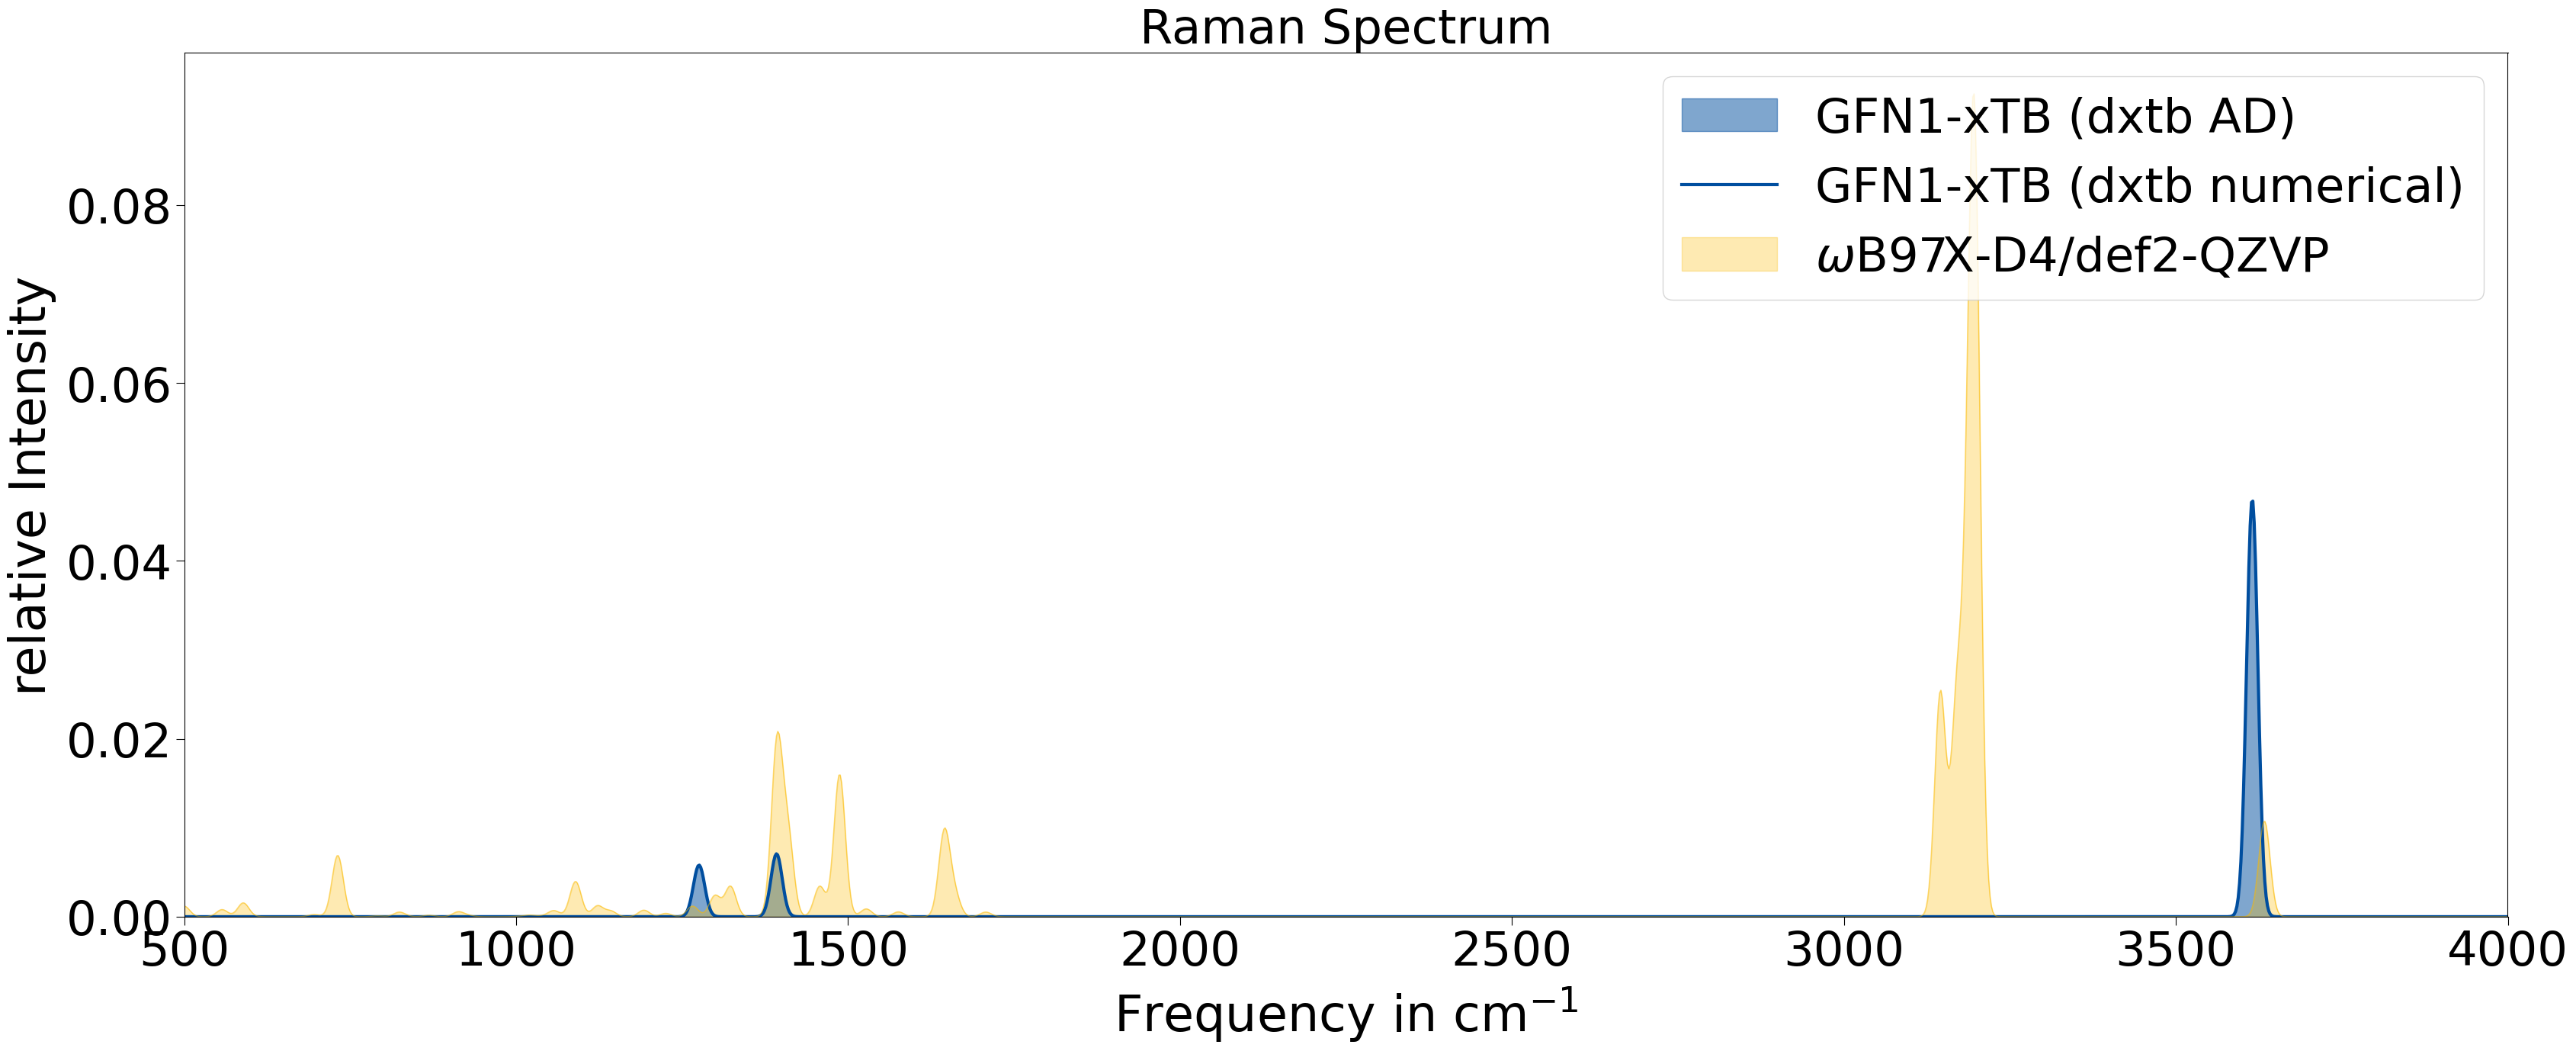

In [15]:
print_spectrum2(freqs_dxtb, ints_dxtb, freqs_dxtb_num, ints_dxtb_num, freqs_dft, ints_dft)

# PySCF

In [16]:
import pyscf

In [17]:
mol = dxtb.mol.external.M(numbers, positions)
mol.intor("int1e_rr").shape

(9, 10, 10)

In [18]:
quad = mol.intor('int1e_rr').reshape(3,3,mol.nao,mol.nao)
quad[0]

array([[[ 4.73362017e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  5.35374753e-02, -2.33585277e-03,
          5.35374753e-02, -2.33585277e-03,  2.80056357e-02,
         -1.11299118e-02],
        [ 0.00000000e+00,  2.40460452e-01,  0.00000000e+00,
          0.00000000e+00,  1.01288195e-01,  3.35292795e-02,
         -1.01288195e-01, -3.35292795e-02,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  8.01534841e-02,
          0.00000000e+00, -3.26945036e-02, -2.14631508e-03,
         -3.26945036e-02, -2.14631508e-03,  2.82661197e-02,
          1.64309596e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          8.01534841e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 5.35374753e-02,  1.01288195e-01, -3.26945036e-02,
          0.00000000e+00,  2.36399534e-01, -1.48908380e-02,
          2.71839051e-02, -3.39629085e-02,  2.773683